### This notebook is created for detecting gender discriminatory speech from non-gender discriminatory speech.

- Data Cleaning
- Modeling:
    - Training
    - Evaluation

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import detectgenderspeech as dgs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import numpy as np

## Read the data 

In [83]:
df = pd.read_csv('df_gender_speech.csv')
df_clean = dgs.wash_pandas_str(df)
df_clean.head()  

,text,label
0,Make me a sandwich.,1
1,It is a men thing.,1
2,Please Miss be nice and bring us some coffee,1
3,All feminism is radical.,1
4,Women belong in the kintchen.,1


Count of entries in dataset

In [84]:
print('There are {} entries and {} columns in dataset'.format(df.shape[0],df.shape[1]))

There are 1001 entries and 2 columns in dataset


## Class distribution

Checking class distribution of data. We have two classes:
1. Gender discriminatory speech
2. Non Gender discriminatory speech

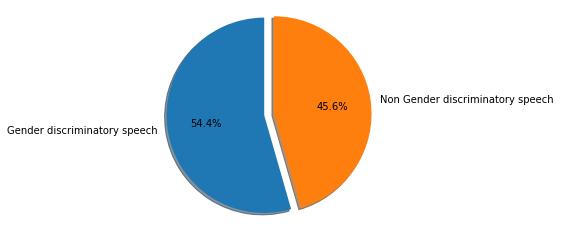

In [85]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
x = df.label.value_counts()
labels = 'Gender discriminatory speech', 'Non Gender discriminatory speech'
sizes = [x[1], x[0]]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Data Analysis
during this step,I check the gender biased language behaviours between gender discriminatory/ non gender discriminatory speech ,and then to make a Bayes-derived feature.

In [86]:
#get the tweets and lables, split the data into 70% training data and 30% test data
X = df_clean.iloc[:,0:1]
Y = df_clean.iloc[:,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 45, test_size  = 0.3)

In [87]:
# train the training data by using Naive Bayes     
train_df,dis_p_prior= dgs.naive_bayes_train(X_train, Y_train)

In [88]:
train_df.head()

,word,cnt_in_non_dis,cnt_in_dis,freq_non_dis,freq_dis,total_cnt
16,women,90,106,0.284810,0.276042,196
46,girls,63,76,0.199367,0.197917,139
55,men,44,51,0.139241,0.132812,95
195,feminist,38,38,0.120253,0.098958,76
52,like,28,45,0.088608,0.117188,73


## Generate Features  

### Word frequency feature part :

In [89]:
# get word frequency feature for svm
word_frequency_feature_train = dgs.naive_bayes_generate_feature(train_df, dis_p_prior, X_train, Y_train)

### Bigram frequency feature part :

In [90]:
#train the training data by using Naive Bayes  
train_df_bigrm, dis_p_prior = dgs.naive_bayes_bigrm_train(X_train, Y_train)

In [91]:
# generate bigram frequency feature for svm
bigrm_frequency_feature_train = dgs.naive_bayes_generate_feature_bigrm(train_df_bigrm, dis_p_prior, X_train, Y_train)

### Bigram- tagging frequency feature part: 

source to learn how to use pos-tags https://stackoverflow.com/questions/60363904/how-to-use-the-universal-pos-tags-with-nltk-pos-tag-function

Bigrams are tagged into their parts-of-speech. 

For example, ('red', 'apple') will be tagged as ('ADJ', 'NOUN').

We use tagset = universal, which has only 18 different types of part-of-speech.

Therefore, the unique tagged bigrams come in 18\*18 = 324 types.

This enables us to build a 324-dimensional feature, which can be fed into SVM directly (which is less efficient for untreated bigrams, since they
may come in many thousands of different types)

In [92]:
# Bigram of Tags using SVM
train_tagged_bigram_features = dgs.tags_bigram_generate_features(X_train) 

##   Training the algorithm 
Support vector machineuse algorithm is used.

### for word frequency feature:

In [93]:
X1 = dgs.conv_array(word_frequency_feature_train)
y = Y_train

In [94]:
# the default parameter for gamma should be 'scale'. I first tried svm.SVC() without written parameters, and a warning sign popped out, saying I should set gamma='scale'.
clf_word = svm.SVC(gamma='scale')
clf_word.fit(X1, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [95]:
#get word frequency of testing data set
word_frequency_feature_test = dgs.naive_bayes_generate_feature(train_df, dis_p_prior, X_test, Y_test)
X2 = dgs.conv_array(word_frequency_feature_test)

###  for bigram frequency

In [96]:
X3 = dgs.conv_array(bigrm_frequency_feature_train)
y = Y_train

In [97]:
clf_bigrm = svm.SVC(gamma='scale')
clf_bigrm.fit(X3, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [100]:
# get bigram frequency testing data set
bigrm_frequency_feature_test = dgs.naive_bayes_generate_feature_bigrm(train_df_bigrm, dis_p_prior, X_test, Y_test)
X4 = dgs.conv_array(bigrm_frequency_feature_test)

###  for tagged bigram feature

In [101]:
clf_tags = svm.SVC(gamma='scale')
clf_tags.fit(train_tagged_bigram_features, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [102]:
test_tagged_bigram_features = dgs.tags_bigram_generate_features(X_test)

## Evaluation the model

### for word frequency feature:

In [103]:
Y_test_nparray = np.array(Y_test)
Y_predict = clf_word.predict(X2)

clf_word.score(X2, Y_test)

0.7308970099667774

In [104]:
# get the confusion matrix to see how our model worked on test set.  
cm_word = confusion_matrix(Y_test, Y_predict)
cm_word 

array([[ 98,  42],
       [ 39, 122]], dtype=int64)

In [105]:
# details of accuracy and recall :
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       140
           1       0.74      0.76      0.75       161

    accuracy                           0.73       301
   macro avg       0.73      0.73      0.73       301
weighted avg       0.73      0.73      0.73       301



### for bigram frequency feature

In [106]:
Y_test_nparray = np.array(Y_test)
Y_predict_2 = clf_bigrm.predict(X4)

clf_bigrm.score(X4, Y_test)

0.6777408637873754

In [107]:
# get the confusion matrix to see how our model worked on test set.  
cm_bigrm = confusion_matrix(Y_test, Y_predict_2)
cm_bigrm

array([[ 93,  47],
       [ 50, 111]], dtype=int64)

In [108]:
# details of accuracy and recall :
print(classification_report(Y_test, Y_predict_2))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66       140
           1       0.70      0.69      0.70       161

    accuracy                           0.68       301
   macro avg       0.68      0.68      0.68       301
weighted avg       0.68      0.68      0.68       301



### for tagged bigram feature

In [109]:
clf_tags.score(test_tagged_bigram_features, Y_test)

0.6777408637873754

Accuracy for tagged bigram feature is 67.7%.

In [110]:
Y_predict_3 = clf_tags.predict(test_tagged_bigram_features)

In [111]:
# get the confusion matrix to see how our model worked on test set.  
cm_tags = confusion_matrix(Y_test, Y_predict_3)
cm_tags

array([[ 86,  54],
       [ 43, 118]], dtype=int64)

In [112]:
# details of accuracy and recall :
print(classification_report(Y_test, Y_predict_3))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       140
           1       0.69      0.73      0.71       161

    accuracy                           0.68       301
   macro avg       0.68      0.67      0.67       301
weighted avg       0.68      0.68      0.68       301



In [113]:
X2.shape

(301, 1)

In [114]:
X1.shape

(700, 1)

In [115]:
joint_features_train = np.concatenate((X1, X3, train_tagged_bigram_features), axis = 1)

In [116]:
joint_features_train.shape

(700, 326)

In [117]:
clf_joint = svm.SVC(gamma='scale')

In [118]:
clf_joint.fit(joint_features_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [130]:
clf_joint.score(X_test_total,Y_test_total)

NameError: name 'X_test_total' is not defined

In [119]:
joint_features_test = np.concatenate((X2, X4, test_tagged_bigram_features), axis = 1)

In [120]:
Y_predict_joint = clf_joint.predict(joint_features_test)

In [121]:
print(classification_report(Y_test, Y_predict_joint))

              precision    recall  f1-score   support

           0       0.67      0.79      0.73       140
           1       0.79      0.66      0.72       161

    accuracy                           0.72       301
   macro avg       0.73      0.73      0.72       301
weighted avg       0.73      0.72      0.72       301



In [122]:
X_test

,text
727,A woman is married primarily for reproduction ...
243,"Girls, stick with math & science in school. Th..."
342,I feel much safer if a male is driving instead...
909,here are goes Im not like the other girls squ...
920,It's one thing to have women in leadership and...
...,...
491,Im a girl and people get really fucking confus...
48,"There are no ugly women, only lazy ones"
805,Dowry of girls with flat Tummy should be paid ...
718,Women just don't have the stamina and logical ...


### Test with a random tweet:

In [123]:
txt = "call me sexist for this idk i hate tiktok men's thirst traps i have not found any one of them hot they all scare me."

In [124]:
txt_pd = pd.DataFrame([txt,])

In [126]:
txt_pd.columns =['text']

In [127]:
rnd_test = dgs.naive_bayes_generate_feature(train_df, dis_p_prior, txt_pd, Y_test)

In [128]:
rnd_test

[0.19483990789072392]